# Imports

In [1]:
from src.datasets import FretOffsetTrainDataset
from torch.utils.data import DataLoader
from src.model import NotationModel, ModelConfig
from torchvision.transforms import InterpolationMode
from pathlib import Path

import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch

### Hyperparameters

In [2]:
BATCH_SIZE = 32
FEATURE_NUM = 2**9
IN_CHANNELS = 2**6
NUM_HEADS = 1
IM_RES = 64
AVG_POOL_DIM = 4
EPOCH_NUM = 30
LR = 1e-4
NUM_WORKERS = 4
NUM_CLASSES = 13

### Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((IM_RES, IM_RES), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

augmentations = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.04, 0.04))
])

In [4]:
from src.util import split_dataset

basepath = Path().resolve().parent.parent
labeled_tabs_path = basepath / "data" / "labelled_fret_offsets.csv"
image_path = basepath / "data" / "dataset" / "frets"

dataset = FretOffsetTrainDataset(labeled_tabs_path, image_path, transform, augmentations=augmentations)
train_set, val_set = split_dataset(dataset, train_ratio=0.9)

kwargs = {
    "num_workers": NUM_WORKERS,
    "batch_size": BATCH_SIZE,
    "pin_memory": True,
}

train_loader = DataLoader(train_set, shuffle=True, **kwargs)
val_loader = DataLoader(val_set, shuffle=False, **kwargs)

Train set size: 423
Val set size: 47


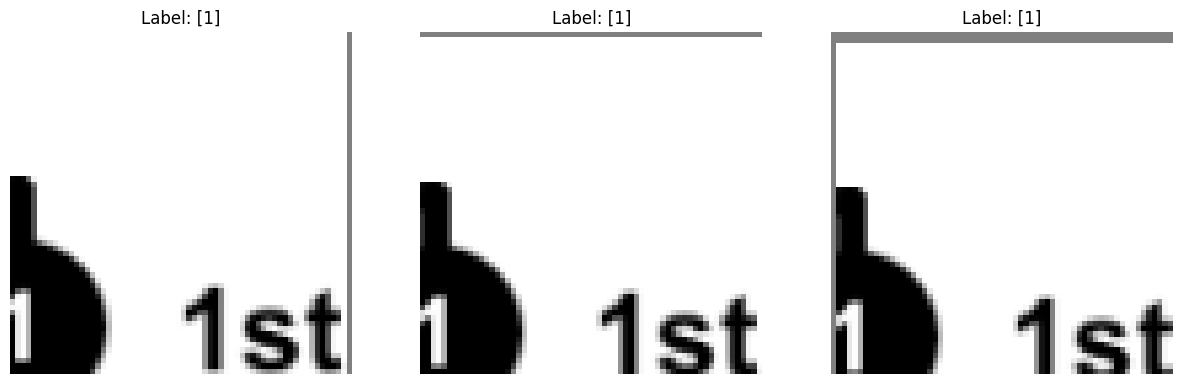

Image shape: torch.Size([1, 64, 64])


In [5]:
from src.util import montage_from_ds

# TODO: fix iteration
montage_from_ds(train_set, 3)
print(f"Image shape: {train_set[0][0].shape}")

### Trainer Setup

In [6]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    dirpath="model_checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}"
)

trainer_config = {
    "log_every_n_steps": 3,
    "enable_model_summary": True,
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    # "profiler": "simple",
    "enable_checkpointing": False, 
    # "callbacks": [checkpoint_callback],
    "logger": False
}

trainer = pl.Trainer(max_epochs=EPOCH_NUM, **trainer_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Tab Prediction

In [7]:
model_config = ModelConfig(num_classes=NUM_CLASSES,
                           feature_num=FEATURE_NUM,
                           im_res=IM_RES,
                           num_heads=NUM_HEADS,
                           in_channels=IN_CHANNELS,
                           avg_pool_dim=AVG_POOL_DIM,
                           learning_rate=LR)
model = NotationModel(model_config)

In [8]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params | Mode 
------------------------------------------------------------
0 | encoder              | Sequential | 11.0 M | train
1 | classification_heads | ModuleList | 106 K  | train
------------------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.400    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


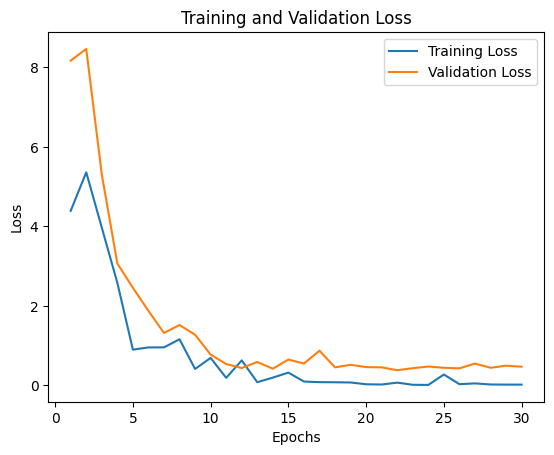

Training loss: 0.0213552
Validation loss: 0.4725042


In [9]:
from src.util import show_loss_info

tab_train_losses = model.train_losses
tab_val_losses = model.val_losses[1:] # PyTorch Lightning performs 1 validation step before training starts
show_loss_info(tab_train_losses, tab_val_losses)

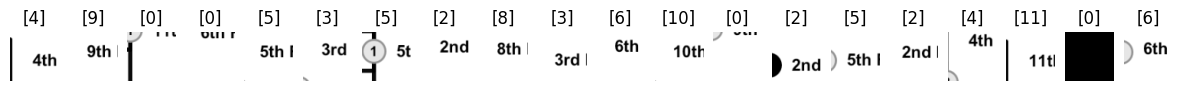

In [10]:
from src.datasets import TestDataset
from src.util import model_montage, montage
import random 
import os

SHOW_NUM = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

filenames = random.choices(os.listdir(image_path), k=SHOW_NUM)
small_predict_dataset = TestDataset.from_dir(image_path, filenames=filenames, transform=transform)
small_predict_loader = DataLoader(small_predict_dataset, shuffle=False, batch_size=BATCH_SIZE)
    
model_montage(small_predict_loader, model, show_num=SHOW_NUM)

In [11]:
val_set.remove_augmentations()
# TODO: Add Test set that has never been seen by the model and doesnt contain augmentations, also for validation set!!
predict_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

misclassified = []
for index, data in enumerate(predict_loader):
    im, label = data
    im = im.to(device)
    classified = model.predict(im)
    if label.item() == classified.item():
        continue
    misclassified.append((im[0], classified))

montage(misclassified, SHOW_NUM)

# TODO: Write function that converts logits to probabilities while not introducing under- / overconfidence
# TODO: Compare confidence of misclassifications to correct classifications
# TODO: Add more metrics other than train / val loss

AttributeError: 'Subset' object has no attribute 'remove_augmentations'